# Introduction

- Task: Multi-class Classification    
- Method: Linear Neural Network
- Library: PyTorch
- Dataset: CIFAR-10
    - https://www.cs.toronto.edu/~kriz/cifar.html
    - The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    - Classes: {airplain, automobile, bird, cat, deer, dog, frog, horse, ship, truck}

# Set Environment

In [74]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [75]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Selected device:", device)

torch.manual_seed(42)

Selected device: cuda


# Process Data

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10('/home/june/__github__/playground/data',
                                 download = True, train = True, transform = transform)

test_dataset = datasets.CIFAR10('/home/june/__github__/playground/data',
                                download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
batch_size = 2048

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                          shuffle=True, num_workers = 0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                         shuffle = False, num_workers = 0)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Define Model

## Model Structure

In [79]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view((x.size(0), -1))
        x = self.fc(x)
        return x

## Hyperparameter & Functions

In [80]:
input_size = 3*32*32
num_classes = 10

model = LinearClassifier(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [81]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

# Train

In [82]:
def train_model(model, cirterion, optimizer, trainloader, num_epochs):
    print("-----Training Started------")
    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0
        
        for images, labels in trainloader: #tqdm
            
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        torch.save(model, './model/Linear.pth')
        
    print("-----Training Completed-----")

In [83]:
num_epochs = 16

train_model(model, criterion, optimizer, trainloader, num_epochs)
writer.flush()
writer.close()

-----Training Started------


100%|██████████| 16/16 [01:38<00:00,  6.15s/it]

-----Training Completed-----


# Test

In [84]:
def test_model(model, testloader):
    
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")

In [85]:
test_model(model, testloader)

100%|██████████| 157/157 [00:01<00:00, 131.88it/s]

Accuracy on test set: 0.4060


# Inference

# Visualize Results

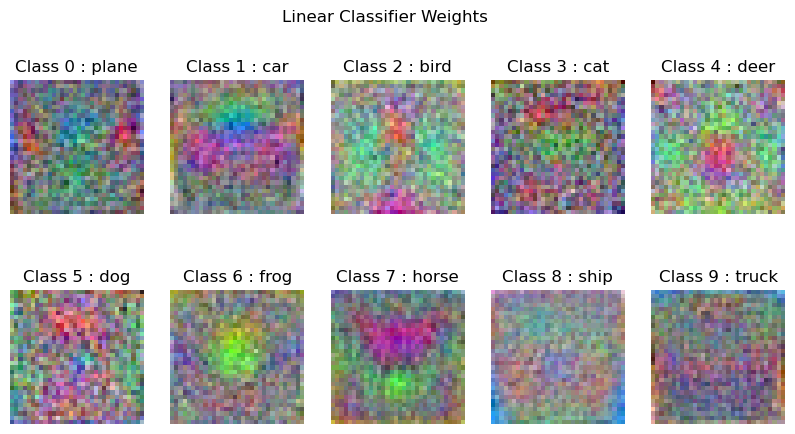

In [86]:
model = torch.load('./model/Linear.pth', weights_only=False)
weights = model.fc.weight.data.cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i+1)
    scaled_weights = (weights[i] - weights[i].min()) / (weights[i].max() - weights[i].min())
    scaled_weights = (scaled_weights * 255).astype(np.uint8)
    plt.imshow(scaled_weights.reshape(3, 32, 32).transpose(1,2,0))
    
    plt.title(f'Class {i} : {classes[i]}')
    plt.axis('off')
plt.suptitle('Linear Classifier Weights')
plt.show()